In [ ]:
# 대화 기록 관리하기
# 대화가 점점 길어질수록 기록이 쌓여서 컨텍스트를 많이 사용하게 됨
# 값비싼 LLM 사용료를 지불할 수 있으며, 잠재적인 오류 발생 가능성이 있슴
# 따라서 대화 기록을 관리해야 됨

In [1]:
%%capture --no-stderr
#%pip install --quiet -U langgraph langchain_anthropic

In [2]:
from dotenv import load_dotenv
load_dotenv('../envls')

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [3]:
# LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [4]:
# 그래프 생성, 이전과 동일함
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

# 지속성을 추가하기 위해 그래프를 컴파일할 때 checkpoint를 추가
memory = SqliteSaver.from_conn_string(":memory:")

@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# 모델은 클로드 하이쿠 사용
model = ChatAnthropic(model_name="claude-3-haiku-20240307")
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

In [5]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

It's nice to meet you, Bob! I'm an AI assistant created by Anthropic. How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I'm afraid I don't actually know your name - you introduced yourself as Bob, but I don't have any other information about your identity. As an AI, I don't have a way to independently verify people's names or identities. I'm happy to continue our conversation, but just wanted to clarify that I don't have any personal knowledge about you beyond what you've directly told me.


In [6]:
# 메시지 필터링
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)
model = ChatAnthropic(model_name="claude-3-haiku-20240307")
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


def filter_messages(messages: list):
    # This is very simple helper function which only ever uses the last two messages
    return messages[-1:]


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = filter_messages(state["messages"])
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

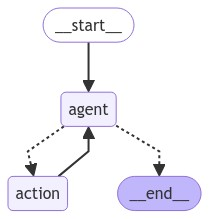

In [7]:
# 랭그래프 클라우드를 사용하면 자동으로 checkpointer가 적용됨
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# This will now not remember the previous messages
# (because we set `messages[-1:]` in the filter messages argument)
input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! It's nice to meet you. As an AI assistant, I don't have a physical form, but I'm here to chat and try my best to help you with any questions or tasks you might have. Please feel free to ask me anything!
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I'm afraid I don't actually know your name. As an AI assistant created by Anthropic, I don't have personal information about you unless you provide it to me directly.
